<a href="https://colab.research.google.com/github/safi50/Deep-Learning/blob/main/PyTorch_Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing DataSet

800 200 800 200


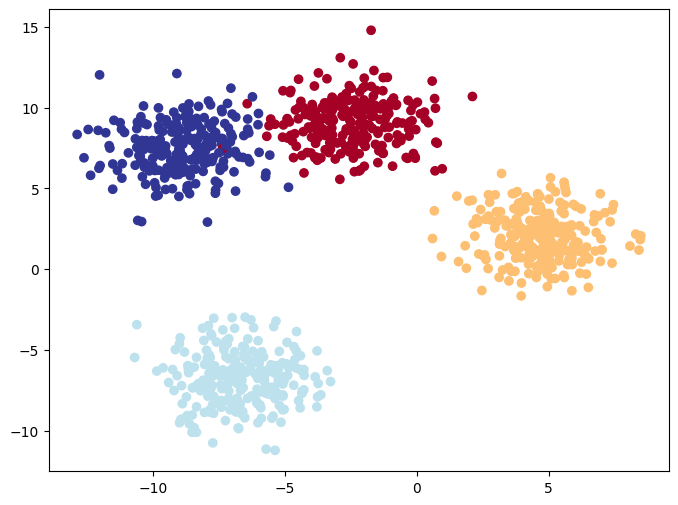

In [66]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Creating Multi-Class Data
X_blob, Y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

# Converting Data into Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.LongTensor)


# Train - Test Split of Data
X_train , X_test, Y_train, Y_test = train_test_split(X_blob,
                                                      Y_blob,
                                                      test_size = 0.2,
                                                      random_state = RANDOM_SEED)

print(len(X_train), len(X_test), len(Y_train), len(Y_test))
 # PLOTTING of Data
plt.figure(figsize=(8,6))
plt.scatter(X_blob[:,0] , X_blob[:,1] , c = Y_blob , cmap=plt.cm.RdYlBu)


### Device Agnostic Code

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Building the Model

In [56]:
class MultiModelClassification(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()

    # Data is Linearly Separable so ReLU isn't necessarily needed here
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model = MultiModelClassification(input_features = 2,
                                 output_features = 4,
                                 hidden_units = 8).to(device)

model



MultiModelClassification(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Loss Function & Optimizer

In [57]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params= model.parameters(),
                           lr = 0.1)

## Accuracy Function

In [58]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100

  return acc

## Plot Decision Boundary Function

In [63]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Model Training Loop

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, Y_train = X_train.to(device) , Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in range(epochs):

  model.train()

  # Forward Pass
  Y_logits = model(X_train)
  Y_preds = torch.softmax(Y_logits, dim = 1).argmax(dim = 1)

  # Calculating Loss and Accuracy
  loss = loss_fn(Y_logits, Y_train)
  acc = accuracy_fn(y_true = Y_train,
                    y_pred = Y_preds)

  optimizer.zero_grad()

  ## Backward Propagation
  loss.backward()
  optimizer.step()

  # Testing LOOP

  model.eval()
  with torch.inference_mode():

    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(y_true = Y_test,
                           y_pred = test_preds)

    # Prinitng Outputs:
    if epoch % 10 == 0:

      print(f"Epoch: {epoch} | Train Loss : {loss:.4f} | Train Accuracy: {acc:.2f}")
      print(f"Epoch: {epoch} | Test  Loss : {test_loss:.4f} | Test Accuracy: {acc:.2f}")



Epoch: 0 | Train Loss : 1.3598 | Train Accuracy: 48.62
Epoch: 0 | Test  Loss : 1.3295 | Test Accuracy: 48.62
Epoch: 10 | Train Loss : 1.1111 | Train Accuracy: 69.62
Epoch: 10 | Test  Loss : 1.0672 | Test Accuracy: 69.62
Epoch: 20 | Train Loss : 0.6915 | Train Accuracy: 96.62
Epoch: 20 | Test  Loss : 0.6941 | Test Accuracy: 96.62
Epoch: 30 | Train Loss : 0.4879 | Train Accuracy: 96.38
Epoch: 30 | Test  Loss : 0.5091 | Test Accuracy: 96.38
Epoch: 40 | Train Loss : 0.3765 | Train Accuracy: 91.12
Epoch: 40 | Test  Loss : 0.3777 | Test Accuracy: 91.12
Epoch: 50 | Train Loss : 0.2510 | Train Accuracy: 97.12
Epoch: 50 | Test  Loss : 0.2540 | Test Accuracy: 97.12
Epoch: 60 | Train Loss : 0.1845 | Train Accuracy: 99.12
Epoch: 60 | Test  Loss : 0.1812 | Test Accuracy: 99.12
Epoch: 70 | Train Loss : 0.1512 | Train Accuracy: 99.25
Epoch: 70 | Test  Loss : 0.1467 | Test Accuracy: 99.25
Epoch: 80 | Train Loss : 0.1275 | Train Accuracy: 99.25
Epoch: 80 | Test  Loss : 0.1225 | Test Accuracy: 99.25
Epo

## Making Predictions

In [64]:
logits = model(X_test)
preds = torch.softmax(logits, dim = 1).argmax(dim = 1)

print(preds[:10])
print(Y_test[:10])


tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')


## Plotting Decision Boundary

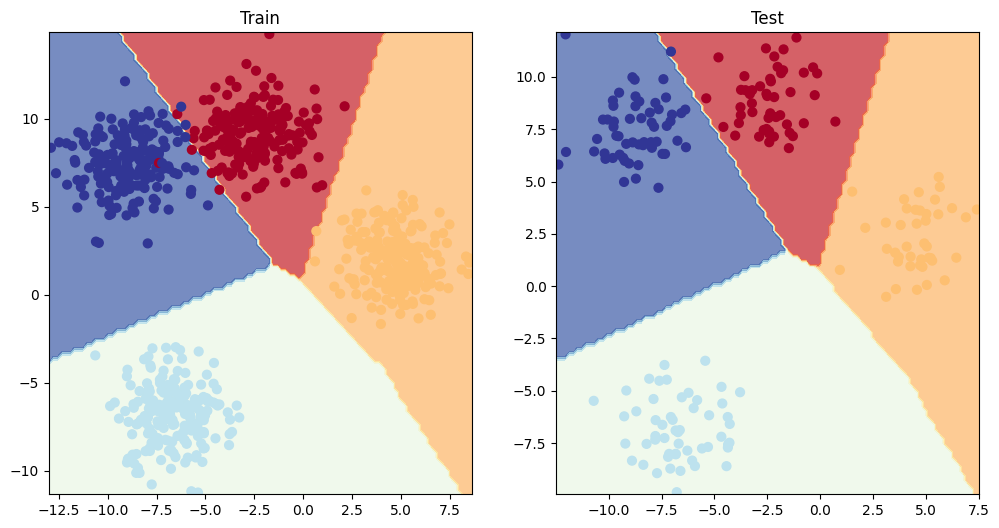

In [67]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, Y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test, Y_test)
